In [2]:
import pandas as pd

# FormalityDetector, data processing and evaluation utils
from writing_assistance import FormalityDetector
from writing_assistance.utils.normalize_data import normalize_avg_score
from writing_assistance.utils.evaluate_model import (
    generate_predictions,
    evaluate_formality_predictions,
    plot_scatter_true_vs_predicted,
    plot_error_histogram,
    generate_confusion_matrix_precision_recall,
    plot_roc_curve,
)

# Models evaluation

This notebook presents evaluation of deberta, xlm_roberta, and gpt (LLM as a judge approach) models on dataset found on Huggingface:

> This dataset contains sentence-level formality annotations used in the 2016 TACL paper "An Empirical Analysis of Formality in Online Communication" (Pavlick and Tetreault, 2016). It includes sentences from four genres (news, blogs, email, and QA forums), all annotated by humans on Amazon Mechanical Turk.

Read more about the dataset: [link](https://huggingface.co/datasets/osyvokon/pavlick-formality-scores)


In [3]:
splits = {'train': 'train.csv', 'test': 'test.csv'}
df = pd.read_csv('hf://datasets/osyvokon/pavlick-formality-scores/' + splits['train'])


In [3]:
df.head()

,domain,avg_score,sentence
0,news,-0.6,Tang was employed at private-equity firm Fried...
1,news,1.0,San Francisco Mayor Gavin Newsom's withdrawal ...
2,answers,-2.8,lol nothing worrying about that.
3,news,0.0,She told Price she wanted to join the Police E...
4,news,1.8,The prime minister is keen to use the autumn p...


In [4]:
df.shape

(9274, 3)

In [5]:
for idx, row in df.iloc[:10].iterrows():
    print(f'Sentence {idx}: ', row['sentence'])


Sentence 0:  Tang was employed at private-equity firm Friedman Fleischer & Lowe.
Sentence 1:  San Francisco Mayor Gavin Newsom's withdrawal from the governor's race followed a meeting with top advisers where he was told that, unless he raised $5 million quickly and appeared to be viable, some of the state's biggest unions would throw their support behind Attorney General Jerry Brown.
Sentence 2:  lol nothing worrying about that.
Sentence 3:  She told Price she wanted to join the Police Explorers, a Boy Scouts group that lets boys and girls learn law enforcement with local police.
Sentence 4:  The prime minister is keen to use the autumn pre-budget statement to announce a new "fiscal stimulus", with billions of pounds of extra money for housing, infrastructure projects and training.
Sentence 5:  Those competencies include mastering fundamental legal skills, support of the firm's culture, demonstration of leadership and business skills, and understanding and effectively managing client n

In [4]:
# normalize avg_score of formality to scale from 0 to 1
normalize_avg_score(df)

,domain,avg_score,sentence
0,news,0.400000,Tang was employed at private-equity firm Fried...
1,news,0.666667,San Francisco Mayor Gavin Newsom's withdrawal ...
2,answers,0.033333,lol nothing worrying about that.
3,news,0.500000,She told Price she wanted to join the Police E...
4,news,0.800000,The prime minister is keen to use the autumn p...
...,...,...,...
9269,answers,0.133333,WHAT WERE YOU THINKING?
9270,answers,0.333333,yes u need Medicine more info http://www.skinc...
9271,answers,0.200000,"REGARDLESS TO WHAT HAS HAPPENED IN THE PAST, H..."
9272,answers,0.000000,bonham you motherfuckking moron.


In [5]:
# shuffle and limit data to 100 records
df_limited = df.sample(frac=1, random_state=42).head(100)

## DeBERTA


[DeBERTa-large formality ranker](https://huggingface.co/s-nlp/deberta-large-formality-) model evaluation. While DeBERTa's initial purpose was ranking, we will use it here as a prediction model.


In [8]:
for idx, row in df_limited.iloc[:10].iterrows():
    pred = FormalityDetector.predict('deberta', row['sentence'])
    print('-' * 100)
    print(f'Sentence: ', row['sentence'])
    print(f"True formality: {row['avg_score']}, Predicted formality: {pred[0]['formal']}")


----------------------------------------------------------------------------------------------------
Sentence:  In 1980, joined the Organization of American States in Washington, first as Deputy Director of the Regional Program for Scientific and Technological Development, then as Advisor to the Secretary General for External Relations, dealing with European and Middle Eastern countries holding Permanent Observer Status to the OAS.
True formality: 0.9666666666666667, Predicted formality: 0.9985135197639465
----------------------------------------------------------------------------------------------------
Sentence:  In March 1942, facing imminent capture by the Japanese, America's commander in the Far East was ordered to slip away to safety in Australia.
True formality: 0.6333333333333333, Predicted formality: 0.9992806315422058
----------------------------------------------------------------------------------------------------
Sentence:  An interesting way to gauge this would be to fi

DeBERTa works quite well for formal texts but tends to overestimate formality in moderately formal sentences. It struggles with casual language, predicting extreme values (close to 0 or 1) for them.


In [6]:
y_true, y_pred = generate_predictions(df_limited, 'deberta')

In [16]:
evaluate_formality_predictions(y_true, y_pred)

,RMSE,MAE,R2
All Data,0.387527,0.336946,-1.977192


DeBERTa's results indicate that the model struggles with accurately predicting formality scores. The RMSE of 0.39 and MAE of 0.34 suggest that, on average, predictions deviate significantly from the true values. The negative R² (-1.98) means the model performs worse than simply predicting the mean formality score for all inputs, implying poor generalization.


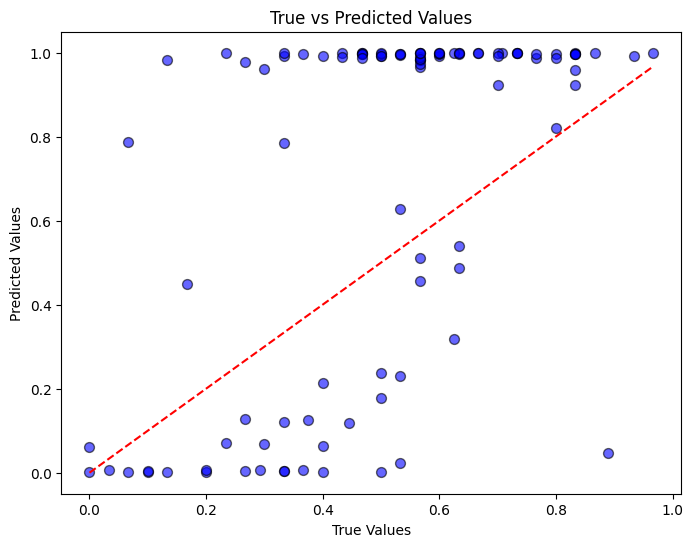

In [17]:
plot_scatter_true_vs_predicted(y_true, y_pred)

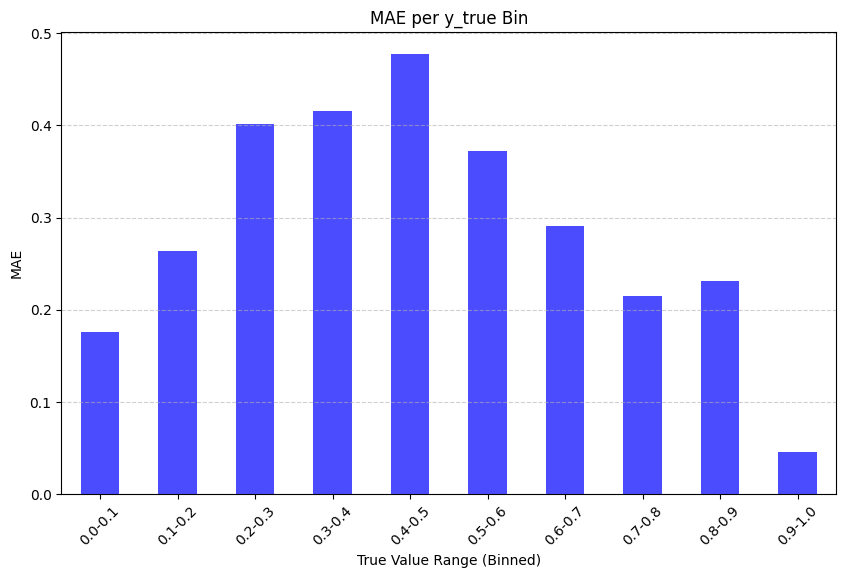

In [7]:
plot_error_histogram(y_true, y_pred)

I experimented with transforming the problem into a binary classification task by converting continuous values into binary (0 or 1) based on a threshold of 0.5, and the confusion matrix below shows the resulting performance, including precision and recall.


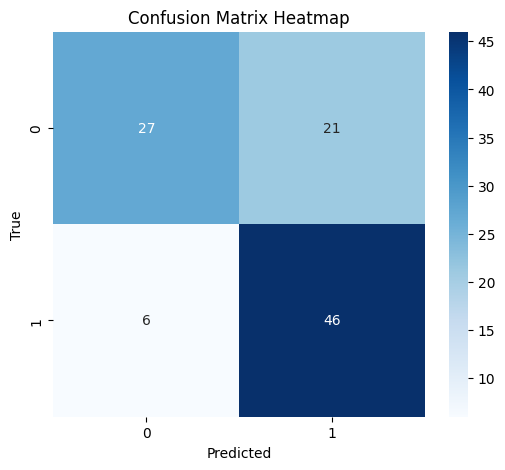

In [ ]:
precision, recall = generate_confusion_matrix_precision_recall(y_true, y_pred)

In [8]:
f'Precision: {precision}, Recall: {recall}'

'Precision: 0.6865671641791045, Recall: 0.8846153846153846'

The model has a precision of 0.69 and a recall of 0.88, indicating good ability to detect positive cases, but it may occasionally misclassify negative cases. We could possibly experiemnt more with threshold value other than 0.5 depending wether we value precision or recall more.


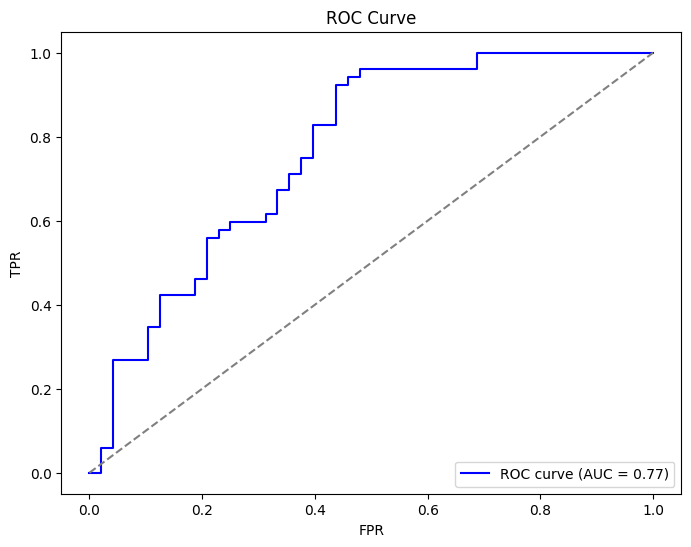

In [8]:
plot_roc_curve(y_true, y_pred)

In summary, while DeBERTa accurately classifies extremely formal and informal texts, it struggles a lot with neutral texts, often assigning them extreme values, as seen in the error histogram, where highest sum of MAE errors occurred for sentences with a true formality score of 0.4-0.5.


## XLM-RoBERTa


[XLM-RoBERTa formality classifier](https://huggingface.co/docs/transformers/model_doc/xlm-roberta) model evaluation


In [ ]:
for idx, row in df_limited.iloc[:10].iterrows():
    pred = FormalityDetector.predict('xlm_roberta', row['sentence'])
    print('-' * 100)
    print(f'Sentence: ', row['sentence'])
    print(f"True formality: {row['avg_score']}, Predicted formality: {pred[0]['formal']}")


----------------------------------------------------------------------------------------------------
Sentence:  In 1980, joined the Organization of American States in Washington, first as Deputy Director of the Regional Program for Scientific and Technological Development, then as Advisor to the Secretary General for External Relations, dealing with European and Middle Eastern countries holding Permanent Observer Status to the OAS.
True formality: 0.9666666666666667, Predicted formality: 0.9986163377761841
----------------------------------------------------------------------------------------------------
Sentence:  In March 1942, facing imminent capture by the Japanese, America's commander in the Far East was ordered to slip away to safety in Australia.
True formality: 0.6333333333333333, Predicted formality: 0.9986440539360046
----------------------------------------------------------------------------------------------------
Sentence:  An interesting way to gauge this would be to fi

XLM-RoBERTa, similar to DeBERTa, often predicts very high formality, even for less formal texts. It tends to overestimate formality, especially in casual or informal sentences, where the predicted score doesn’t match the actual formality.


In [9]:
y_true, y_pred = generate_predictions(df_limited, 'xlm_roberta')

In [25]:
evaluate_formality_predictions(y_true, y_pred)

,RMSE,MAE,R2
All Data,0.422278,0.372722,-2.535084


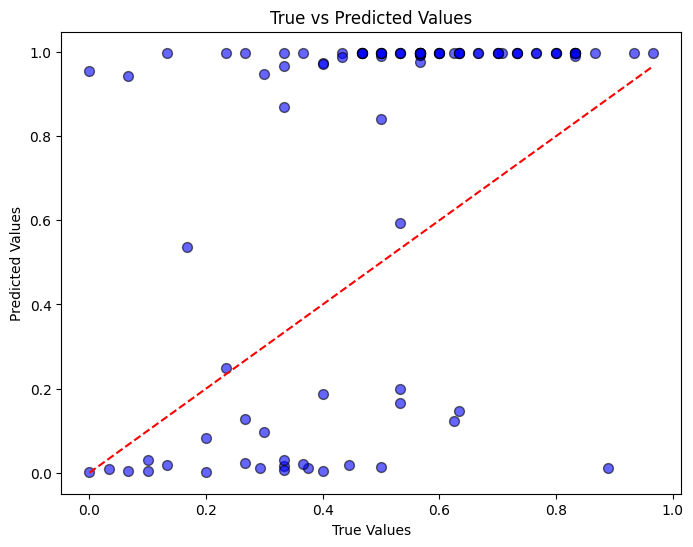

In [26]:
plot_scatter_true_vs_predicted(y_true, y_pred)

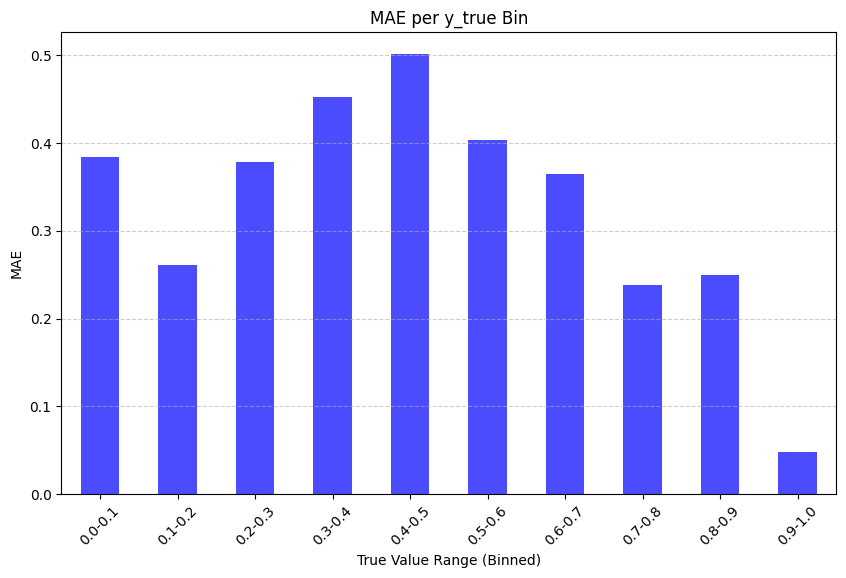

In [10]:
plot_error_histogram(y_true, y_pred)

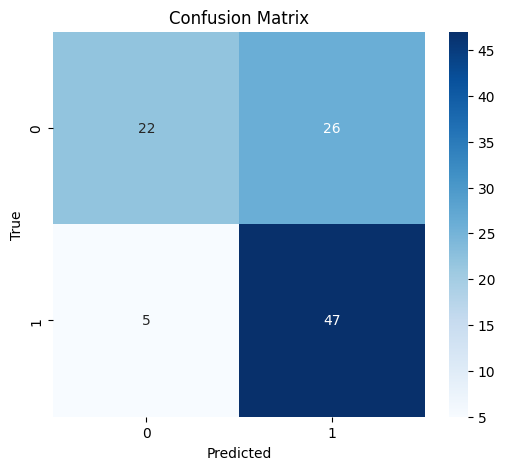

In [11]:
precision, recall = generate_confusion_matrix_precision_recall(y_true, y_pred)

In [11]:
f'Precision: {precision}, Recall: {recall}'

'Precision: 0.6438356164383562, Recall: 0.9038461538461539'

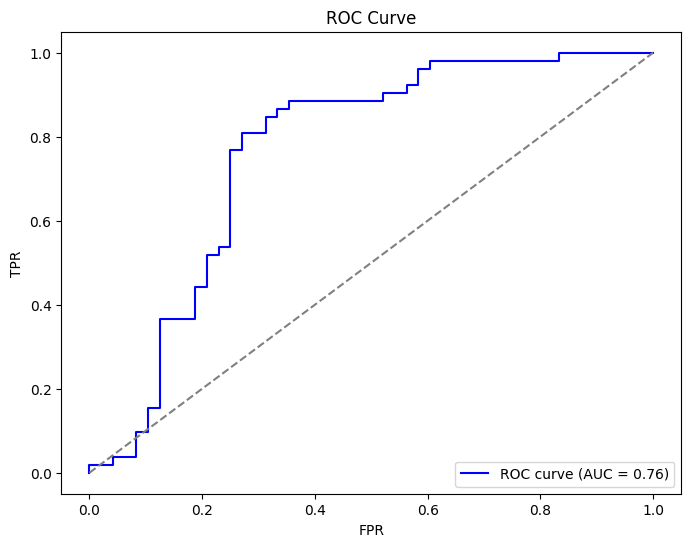

In [12]:
plot_roc_curve(y_true, y_pred)

We can see similar results as seen in DeBERTa with even higher error rates, smaller AUC area and lower precission with slightly higher recall for (0.5 treshold).


## GPT (4o-mini)


In [ ]:
for idx, row in df_limited.iloc[:10].iterrows():
    pred = FormalityDetector.predict('gpt', row['sentence'])
    print('-' * 100)
    print(f'Sentence: ', row['sentence'])
    print(f"True formality: {row['avg_score']}, Predicted formality: {pred[0]['formal']}")


----------------------------------------------------------------------------------------------------
Sentence:  In 1980, joined the Organization of American States in Washington, first as Deputy Director of the Regional Program for Scientific and Technological Development, then as Advisor to the Secretary General for External Relations, dealing with European and Middle Eastern countries holding Permanent Observer Status to the OAS.
True formality: 0.9666666666666667, Predicted formality: 0.9
----------------------------------------------------------------------------------------------------
Sentence:  In March 1942, facing imminent capture by the Japanese, America's commander in the Far East was ordered to slip away to safety in Australia.
True formality: 0.6333333333333333, Predicted formality: 0.8
----------------------------------------------------------------------------------------------------
Sentence:  An interesting way to gauge this would be to figure out the timeline on the V

GPT-4o-mini tends to perform well on formal sentences, with predicted formality scores generally close to the true formality. However, it agin struggles with moderately formal and informal sentences, often underestimating the formality, especially in casual or conversational phrases. It tends to give lower formality scores than expected for less formal texts, but still captures the overall trend for more formal sentences. We can see taht The model rounds formality values to the nearest 0.1, which can affect the precision of the predictions. Improving the prompt could lead to more accurate results.


In [13]:
y_true, y_pred = generate_predictions(df_limited, 'gpt')

In [17]:
evaluate_formality_predictions(y_true, y_pred)

,RMSE,MAE,R2
All Data,0.20489,0.162417,0.167764


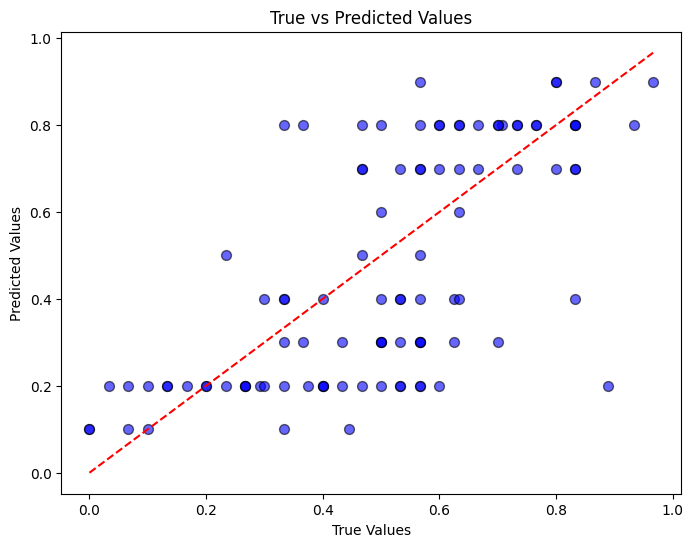

In [18]:
plot_scatter_true_vs_predicted(y_true, y_pred)

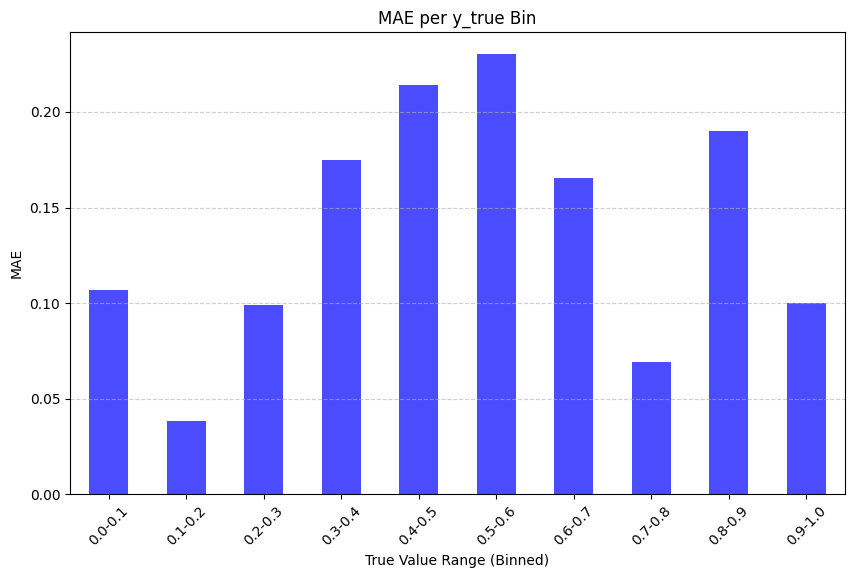

In [14]:
plot_error_histogram(y_true, y_pred)

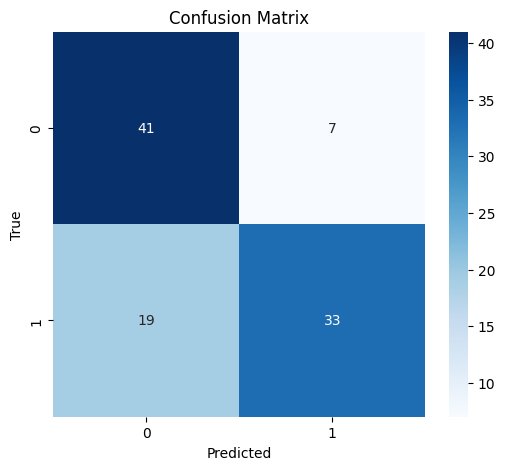

In [19]:
precision, recall = generate_confusion_matrix_precision_recall(y_true, y_pred)

In [ ]:
f'Precision: {precision}, Recall: {recall}'

'Precision: 0.825, Recall: 0.6346153846153846'

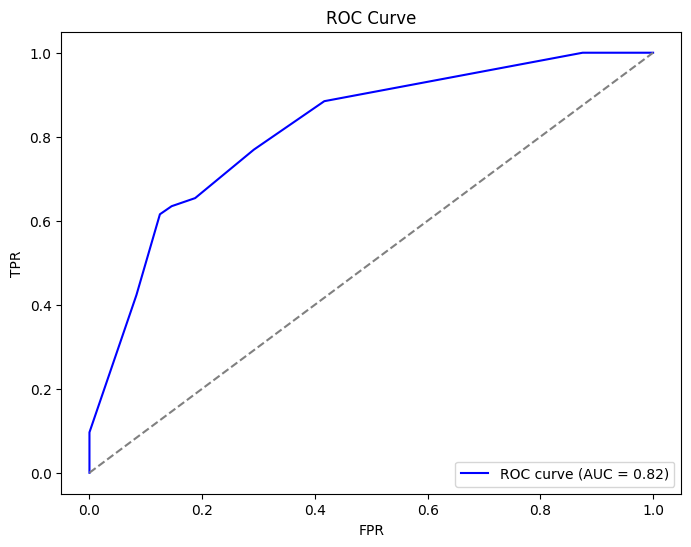

In [15]:
plot_roc_curve(y_true, y_pred)

As seen in the charts above and the error rates, the model performs much better than DeBERTa and XLM-RoBERTa. However, neutral sentences still pose the biggest challenge
